In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import math

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
listed = drive.ListFile({'q': "title contains '.csv' and 'root' in parents"}).GetList()
for file in listed:
  print('title {}, id {}'.format(file['title'], file['id']))

title colors.csv, id 1qPfYyiIgkOD8vQQzCWmVUYS5fdA1NRXX
title DatasetModified.csv, id 1UbmK-Qw1JlFF4SPhxEAfLnvrz3IZUJQH
title Dataset.csv, id 1Z8pgIEShUKlmFQ_wogne-0VNBex1zaPG


In [ ]:
file_id = '1JJoCBQhm51Zvf_IQEBhXbsRKQ5GflihO'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

downloaded.GetContentFile('DatasetModified.csv')


ApiRequestError: ignored

In [ ]:
data = pd.read_csv('DatasetModified.csv')
data.head()
data.shape

FileNotFoundError: ignored

In [ ]:
data.shape

(547308, 30)

In [ ]:
data.ModelCode.unique().shape

(5385,)

In [ ]:
data.describe()

,Adv.EMIno,LoanTenure,EMI,AreaCode,AssetCost,LoanAmount,DownPayment,BouncedTimes,Buss. Mon with Cust.,FuturePrinciple,OverallMaxLoanAmount,UnsecMaxLoanAmount,Timelastloan,TimelastpersonalLoan,TimelastLivepersonalLoan,TimelastClosedpersonalLoan,TimelastLiveBusinnessLoan,TimelastConsumerLoan,SELF_PAY
count,547308.000000,547308.000000,547308.000000,547308.000000,547308.000000,547308.000000,547308.000000,547308.000000,547308.000000,547308.000000,5.051170e+05,5.050860e+05,505133.000000,53828.000000,44545.000000,20692.000000,28977.000000,505083.000000,547308.000000
mean,2.525258,10.627257,1854.651699,3031.169950,21096.872478,19365.248524,4403.523499,3.025395,3.788428,12352.398898,9.473669e+04,3.556649e+04,134.033773,472.769116,334.807700,1035.795766,581.842461,286.042351,0.063085
std,1.412450,2.243713,750.749861,27.873827,10360.971390,8045.232442,2770.269504,1.977241,2.194184,6951.576244,4.983030e+05,2.530962e+05,98.484353,801.639792,482.727278,1236.883883,925.704343,431.687425,0.243116
min,0.000000,6.000000,459.000000,3000.000000,5500.000000,5000.000000,0.000000,1.000000,1.000000,0.000000,9.270000e+02,5.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,0.000000
25%,2.000000,10.000000,1334.000000,3007.000000,14000.000000,13591.000000,3130.000000,1.000000,2.000000,7585.120000,1.570000e+04,1.450000e+04,79.000000,97.000000,98.000000,132.000000,130.000000,110.000000,0.000000
50%,3.000000,10.000000,1667.000000,3025.000000,18000.000000,17500.000000,4480.000000,3.000000,4.000000,11099.610000,2.300000e+04,1.899000e+04,125.000000,203.000000,199.000000,572.000000,271.000000,174.000000,0.000000
75%,4.000000,12.000000,2167.000000,3054.000000,24000.000000,22900.000000,5894.000000,4.000000,5.000000,15599.450000,5.300000e+04,2.630000e+04,183.000000,477.000000,406.000000,1467.000000,615.000000,259.000000,0.000000
max,8.000000,36.000000,16667.000000,3115.000000,263000.000000,212668.000000,54224.000000,16.000000,16.000000,177225.810000,1.000000e+08,7.248054e+07,11076.000000,7029.000000,6796.000000,7029.000000,12618.000000,8737.000000,1.000000


In [ ]:
data.describe().shape

(8, 19)

In [ ]:
data.isnull().sum()

CUST_ID                            0
Each Month Last Date               0
DateCA                             0
P.Type                             0
ModelCode                          0
DealerCode                         0
AppDownloaded                      0
Adv.EMIno                          0
LoanTenure                         0
EMI                                0
DOB                                0
AreaCode                           0
AssetCost                          0
LoanAmount                         0
DownPayment                        0
Qualifi.                           0
Employ. Type                       0
ResidentType                    3936
BouncedTimes                       0
Buss. Mon with Cust.               0
FuturePrinciple                    0
OverallMaxLoanAmount           42191
UnsecMaxLoanAmount             42222
Timelastloan                   42175
TimelastpersonalLoan          493480
TimelastLivepersonalLoan      502763
TimelastClosedpersonalLoan    526616
T

In [ ]:
data.AppDownloaded.replace(('Y', 'N'), (1, 0), inplace = True)
data.head()

,CUST_ID,Each Month Last Date,DateCA,P.Type,ModelCode,DealerCode,AppDownloaded,Adv.EMIno,LoanTenure,EMI,DOB,AreaCode,AssetCost,LoanAmount,DownPayment,Qualifi.,Employ. Type,ResidentType,BouncedTimes,Buss. Mon with Cust.,FuturePrinciple,OverallMaxLoanAmount,UnsecMaxLoanAmount,Timelastloan,TimelastpersonalLoan,TimelastLivepersonalLoan,TimelastClosedpersonalLoan,TimelastLiveBusinnessLoan,TimelastConsumerLoan,SELF_PAY
0,CNO000001,31-03-2019,21-09-2018,MOBILE,CD00124531,CD04818,1,3,10,1799,16-11-1978,3054,17990,17990,5527,12TH,SELF,OWNED,3,5,8994.73,17990.0,17990.0,191.0,NaN,NaN,NaN,NaN,191.0,0
1,CNO000002,30-04-2019,21-09-2018,MOBILE,CD00124531,CD04818,1,3,10,1799,16-11-1978,3054,17990,17990,5527,12TH,SELF,OWNED,4,6,7195.82,17990.0,17990.0,221.0,NaN,NaN,NaN,NaN,221.0,0
2,CNO000003,31-05-2019,21-09-2018,MOBILE,CD00124531,CD04818,1,3,10,1799,16-11-1978,3054,17990,17990,5527,12TH,SELF,OWNED,5,7,5396.89,17990.0,17990.0,252.0,NaN,NaN,NaN,NaN,252.0,0
3,CNO000004,31-01-2019,21-06-2018,MOBILE,CD0005249,CD02428,1,2,12,2834,10-03-1990,3078,35900,34000,5798,POST-GRADUATE,SAL,OWNED,1,7,14168.46,34000.0,34000.0,224.0,NaN,NaN,NaN,NaN,224.0,0
4,CNO000005,30-04-2019,21-06-2018,MOBILE,CD0005249,CD02428,1,2,12,2834,10-03-1990,3078,35900,34000,5798,POST-GRADUATE,SAL,OWNED,2,10,5667.69,34000.0,34000.0,313.0,NaN,NaN,NaN,NaN,313.0,0


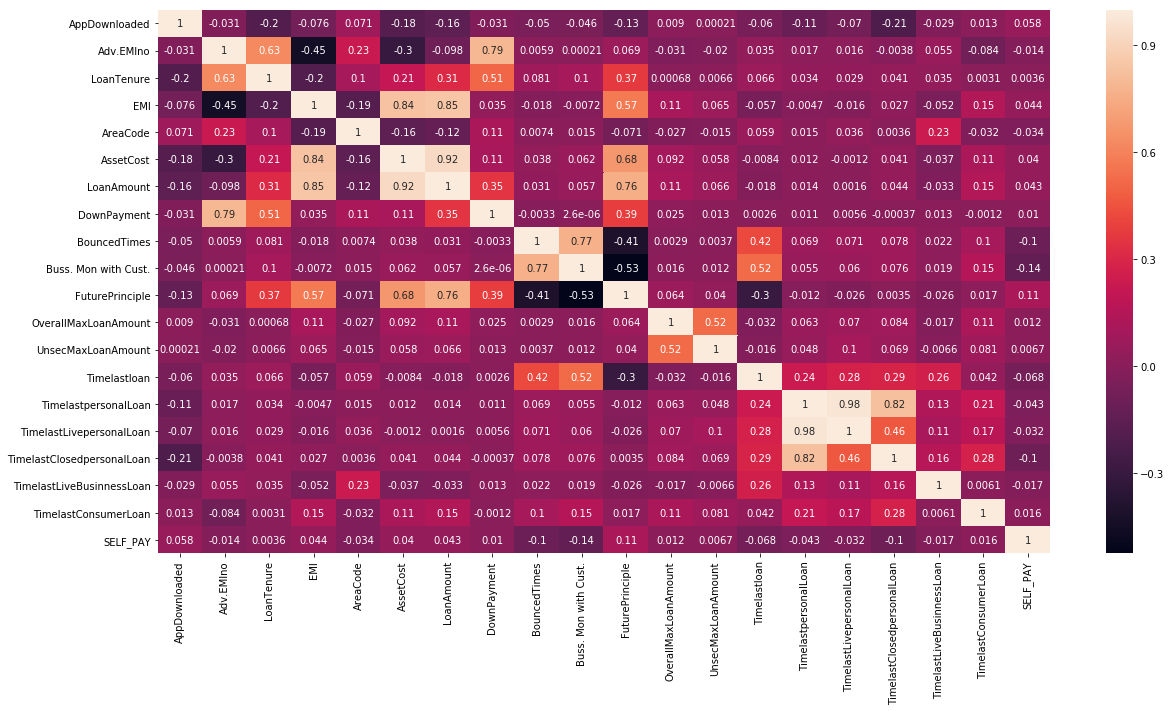

In [ ]:
Var_Corr = data.corr()

plt.figure(figsize=(20,10))

sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)

In [ ]:
data.CUST_ID.unique().shape

(547308,)



Putting the missing values as zero and mean depending upon sizes of missingvalues



In [ ]:
data.TimelastLiveBusinnessLoan = data.TimelastLiveBusinnessLoan.fillna(0)
data.TimelastpersonalLoan = data.TimelastpersonalLoan.fillna(0)
data.TimelastClosedpersonalLoan = data.TimelastClosedpersonalLoan.fillna(0)
data.TimelastLivepersonalLoan = data.TimelastLivepersonalLoan.fillna(0)
data.OverallMaxLoanAmount = data.OverallMaxLoanAmount.fillna(data.OverallMaxLoanAmount.mean())
data.UnsecMaxLoanAmount = data.UnsecMaxLoanAmount.fillna(data.UnsecMaxLoanAmount.mean())
data.Timelastloan = data.Timelastloan.fillna(data.Timelastloan.mean())
data.TimelastConsumerLoan = data.TimelastConsumerLoan.fillna(data.TimelastConsumerLoan.mean())

data.ResidentType = data.ResidentType.fillna('OWNED')
# data.ResidentType.unique()




**Feature Engineering** 

In [ ]:
Interest = data['LoanAmount']+data['DownPayment']-data['AssetCost']
SecuredLoans = data['OverallMaxLoanAmount']-data['UnsecMaxLoanAmount']
data.insert(13,"Interest",Interest,True)
data.insert(24,"SecuredLoans",SecuredLoans,True)
data.head()


,CUST_ID,Each Month Last Date,DateCA,P.Type,ModelCode,DealerCode,AppDownloaded,Adv.EMIno,LoanTenure,EMI,DOB,AreaCode,AssetCost,Interest,LoanAmount,DownPayment,Qualifi.,Employ. Type,ResidentType,BouncedTimes,Buss. Mon with Cust.,FuturePrinciple,OverallMaxLoanAmount,UnsecMaxLoanAmount,SecuredLoans,Timelastloan,TimelastpersonalLoan,TimelastLivepersonalLoan,TimelastClosedpersonalLoan,TimelastLiveBusinnessLoan,TimelastConsumerLoan,SELF_PAY
0,CNO000001,31-03-2019,21-09-2018,MOBILE,CD00124531,CD04818,1,3,10,1799,16-11-1978,3054,17990,5527,17990,5527,12TH,SELF,OWNED,3,5,8994.73,17990.0,17990.0,0.0,191.0,0.0,0.0,0.0,0.0,191.0,0
1,CNO000002,30-04-2019,21-09-2018,MOBILE,CD00124531,CD04818,1,3,10,1799,16-11-1978,3054,17990,5527,17990,5527,12TH,SELF,OWNED,4,6,7195.82,17990.0,17990.0,0.0,221.0,0.0,0.0,0.0,0.0,221.0,0
2,CNO000003,31-05-2019,21-09-2018,MOBILE,CD00124531,CD04818,1,3,10,1799,16-11-1978,3054,17990,5527,17990,5527,12TH,SELF,OWNED,5,7,5396.89,17990.0,17990.0,0.0,252.0,0.0,0.0,0.0,0.0,252.0,0
3,CNO000004,31-01-2019,21-06-2018,MOBILE,CD0005249,CD02428,1,2,12,2834,10-03-1990,3078,35900,3898,34000,5798,POST-GRADUATE,SAL,OWNED,1,7,14168.46,34000.0,34000.0,0.0,224.0,0.0,0.0,0.0,0.0,224.0,0
4,CNO000005,30-04-2019,21-06-2018,MOBILE,CD0005249,CD02428,1,2,12,2834,10-03-1990,3078,35900,3898,34000,5798,POST-GRADUATE,SAL,OWNED,2,10,5667.69,34000.0,34000.0,0.0,313.0,0.0,0.0,0.0,0.0,313.0,0


In [ ]:
data['DOB']=data['DOB'].apply(lambda x: pd.to_datetime('today').year-pd.to_datetime(x).year)

data.head()

,CUST_ID,Each Month Last Date,DateCA,P.Type,ModelCode,DealerCode,AppDownloaded,Adv.EMIno,LoanTenure,EMI,DOB,AreaCode,AssetCost,Interest,LoanAmount,DownPayment,Qualifi.,Employ. Type,ResidentType,BouncedTimes,Buss. Mon with Cust.,FuturePrinciple,OverallMaxLoanAmount,UnsecMaxLoanAmount,SecuredLoans,Timelastloan,TimelastpersonalLoan,TimelastLivepersonalLoan,TimelastClosedpersonalLoan,TimelastLiveBusinnessLoan,TimelastConsumerLoan,SELF_PAY
0,CNO000001,31-03-2019,21-09-2018,MOBILE,CD00124531,CD04818,1,3,10,1799,41,3054,17990,5527,17990,5527,12TH,SELF,OWNED,3,5,8994.73,17990.0,17990.0,0.0,191.0,0.0,0.0,0.0,0.0,191.0,0
1,CNO000002,30-04-2019,21-09-2018,MOBILE,CD00124531,CD04818,1,3,10,1799,41,3054,17990,5527,17990,5527,12TH,SELF,OWNED,4,6,7195.82,17990.0,17990.0,0.0,221.0,0.0,0.0,0.0,0.0,221.0,0
2,CNO000003,31-05-2019,21-09-2018,MOBILE,CD00124531,CD04818,1,3,10,1799,41,3054,17990,5527,17990,5527,12TH,SELF,OWNED,5,7,5396.89,17990.0,17990.0,0.0,252.0,0.0,0.0,0.0,0.0,252.0,0
3,CNO000004,31-01-2019,21-06-2018,MOBILE,CD0005249,CD02428,1,2,12,2834,29,3078,35900,3898,34000,5798,POST-GRADUATE,SAL,OWNED,1,7,14168.46,34000.0,34000.0,0.0,224.0,0.0,0.0,0.0,0.0,224.0,0
4,CNO000005,30-04-2019,21-06-2018,MOBILE,CD0005249,CD02428,1,2,12,2834,29,3078,35900,3898,34000,5798,POST-GRADUATE,SAL,OWNED,2,10,5667.69,34000.0,34000.0,0.0,313.0,0.0,0.0,0.0,0.0,313.0,0


In [ ]:

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le =LabelEncoder()
# X[:,3]=le.fit_transform(X[:,3])
                        
data['P.Type']=le.fit_transform(data['P.Type'])
data['Employ. Type']=le.fit_transform(data['Employ. Type'])
data['ResidentType']=le.fit_transform(data['ResidentType'])
data.head()


,CUST_ID,Each Month Last Date,DateCA,P.Type,ModelCode,DealerCode,AppDownloaded,Adv.EMIno,LoanTenure,EMI,DOB,AreaCode,AssetCost,Interest,LoanAmount,DownPayment,Qualifi.,Employ. Type,ResidentType,BouncedTimes,Buss. Mon with Cust.,FuturePrinciple,OverallMaxLoanAmount,UnsecMaxLoanAmount,SecuredLoans,Timelastloan,TimelastpersonalLoan,TimelastLivepersonalLoan,TimelastClosedpersonalLoan,TimelastLiveBusinnessLoan,TimelastConsumerLoan,SELF_PAY
0,CNO000001,31-03-2019,21-09-2018,8,CD00124531,CD04818,1,3,10,1799,41,3054,17990,5527,17990,5527,12TH,1,0,3,5,8994.73,17990.0,17990.0,0.0,191.0,0.0,0.0,0.0,0.0,191.0,0
1,CNO000002,30-04-2019,21-09-2018,8,CD00124531,CD04818,1,3,10,1799,41,3054,17990,5527,17990,5527,12TH,1,0,4,6,7195.82,17990.0,17990.0,0.0,221.0,0.0,0.0,0.0,0.0,221.0,0
2,CNO000003,31-05-2019,21-09-2018,8,CD00124531,CD04818,1,3,10,1799,41,3054,17990,5527,17990,5527,12TH,1,0,5,7,5396.89,17990.0,17990.0,0.0,252.0,0.0,0.0,0.0,0.0,252.0,0
3,CNO000004,31-01-2019,21-06-2018,8,CD0005249,CD02428,1,2,12,2834,29,3078,35900,3898,34000,5798,POST-GRADUATE,0,0,1,7,14168.46,34000.0,34000.0,0.0,224.0,0.0,0.0,0.0,0.0,224.0,0
4,CNO000005,30-04-2019,21-06-2018,8,CD0005249,CD02428,1,2,12,2834,29,3078,35900,3898,34000,5798,POST-GRADUATE,0,0,2,10,5667.69,34000.0,34000.0,0.0,313.0,0.0,0.0,0.0,0.0,313.0,0


In [ ]:
data['AreaCode']=le.fit_transform(data['AreaCode'])
data.head()

,CUST_ID,Each Month Last Date,DateCA,P.Type,ModelCode,DealerCode,AppDownloaded,Adv.EMIno,LoanTenure,EMI,DOB,AreaCode,AssetCost,Interest,LoanAmount,DownPayment,Qualifi.,Employ. Type,ResidentType,BouncedTimes,Buss. Mon with Cust.,FuturePrinciple,OverallMaxLoanAmount,UnsecMaxLoanAmount,SecuredLoans,Timelastloan,TimelastpersonalLoan,TimelastLivepersonalLoan,TimelastClosedpersonalLoan,TimelastLiveBusinnessLoan,TimelastConsumerLoan,SELF_PAY
0,CNO000001,31-03-2019,21-09-2018,8,CD00124531,CD04818,1,3,10,1799,41,20,17990,5527,17990,5527,12TH,1,0,3,5,8994.73,17990.0,17990.0,0.0,191.0,0.0,0.0,0.0,0.0,191.0,0
1,CNO000002,30-04-2019,21-09-2018,8,CD00124531,CD04818,1,3,10,1799,41,20,17990,5527,17990,5527,12TH,1,0,4,6,7195.82,17990.0,17990.0,0.0,221.0,0.0,0.0,0.0,0.0,221.0,0
2,CNO000003,31-05-2019,21-09-2018,8,CD00124531,CD04818,1,3,10,1799,41,20,17990,5527,17990,5527,12TH,1,0,5,7,5396.89,17990.0,17990.0,0.0,252.0,0.0,0.0,0.0,0.0,252.0,0
3,CNO000004,31-01-2019,21-06-2018,8,CD0005249,CD02428,1,2,12,2834,29,24,35900,3898,34000,5798,POST-GRADUATE,0,0,1,7,14168.46,34000.0,34000.0,0.0,224.0,0.0,0.0,0.0,0.0,224.0,0
4,CNO000005,30-04-2019,21-06-2018,8,CD0005249,CD02428,1,2,12,2834,29,24,35900,3898,34000,5798,POST-GRADUATE,0,0,2,10,5667.69,34000.0,34000.0,0.0,313.0,0.0,0.0,0.0,0.0,313.0,0


In [ ]:

X = data['P.Type']
X=pd.DataFrame(X)
Y = data['ResidentType']
Y = pd.DataFrame(Y)
Z = data['Employ. Type']
Z= pd.DataFrame(Z)
U = data['AreaCode']
U = pd.DataFrame(U)

In [ ]:
ohc=OneHotEncoder()
X=ohc.fit_transform(X).toarray()
Y=ohc.fit_transform(Y).toarray()
Z=ohc.fit_transform(Z).toarray()
U = ohc.fit_transform(U).toarray()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

In [ ]:
X=pd.DataFrame(X)
X.drop(0,inplace = True,axis=1)
Y=pd.DataFrame(Y)
Y.drop(0,inplace = True,axis=1)
Z=pd.DataFrame(Z)
Z.drop(0,inplace = True,axis=1)
U = pd.DataFrame(U)
U.drop(0, inplace = True, axis=1)

In [ ]:

X.rename(columns = {1 : 'CAM',2:'COOLER',3:'DSW',4:'EC',5:'FRIDGE',6:'HT',7:'LAP',8:'MOBILE',9:'MWO',10:'TV',11:'WAM',12:'WPR'},inplace=True)

Y.rename(columns = {1: 'RENTED'}, inplace=True)
Z.rename(columns = {1: 'SELF'}, inplace =True)
U.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
data.drop('P.Type',axis=1,inplace=True)
data.drop('ResidentType',axis=1,inplace=True)
data.drop('Employ. Type',axis=1,inplace=True)
data.drop('AreaCode', axis = 1, inplace = True)

In [ ]:
data = pd.concat((data,X,Y,Z,U),axis=1)
data.head()



,CUST_ID,Each Month Last Date,DateCA,ModelCode,DealerCode,AppDownloaded,Adv.EMIno,LoanTenure,EMI,DOB,AssetCost,Interest,LoanAmount,DownPayment,Qualifi.,BouncedTimes,Buss. Mon with Cust.,FuturePrinciple,OverallMaxLoanAmount,UnsecMaxLoanAmount,SecuredLoans,Timelastloan,TimelastpersonalLoan,TimelastLivepersonalLoan,TimelastClosedpersonalLoan,TimelastLiveBusinnessLoan,TimelastConsumerLoan,SELF_PAY,CAM,COOLER,DSW,EC,FRIDGE,HT,LAP,MOBILE,MWO,TV,WAM,WPR,RENTED,SELF,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,CNO000001,31-03-2019,21-09-2018,CD00124531,CD04818,1,3,10,1799,41,17990,5527,17990,5527,12TH,3,5,8994.73,17990.0,17990.0,0.0,191.0,0.0,0.0,0.0,0.0,191.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CNO000002,30-04-2019,21-09-2018,CD00124531,CD04818,1,3,10,1799,41,17990,5527,17990,5527,12TH,4,6,7195.82,17990.0,17990.0,0.0,221.0,0.0,0.0,0.0,0.0,221.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CNO000003,31-05-2019,21-09-2018,CD00124531,CD04818,1,3,10,1799,41,17990,5527,17990,5527,12TH,5,7,5396.89,17990.0,17990.0,0.0,252.0,0.0,0.0,0.0,0.0,252.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CNO000004,31-01-2019,21-06-2018,CD0005249,CD02428,1,2,12,2834,29,35900,3898,34000,5798,POST-GRADUATE,1,7,14168.46,34000.0,34000.0,0.0,224.0,0.0,0.0,0.0,0.0,224.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,CNO000005,30-04-2019,21-06-2018,CD0005249,CD02428,1,2,12,2834,29,35900,3898,34000,5798,POST-GRADUATE,2,10,5667.69,34000.0,34000.0,0.0,313.0,0.0,0.0,0.0,0.0,313.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
a = list(np.unique(data['Qualifi.']))
a

['12TH',
 'GRADUATE',
 'OTHERS',
 'POST-GRADUATE',
 'PROFESSIONAL',
 'SSC',
 'UNDER GRADUATE']

Visualizing the qualification and self play columns.

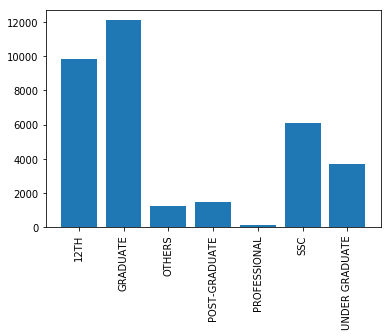

[164079, 127468, 36460, 13539, 2782, 113102, 55351]
['12TH', 'GRADUATE', 'OTHERS', 'POST-GRADUATE', 'PROFESSIONAL', 'SSC', 'UNDER GRADUATE']


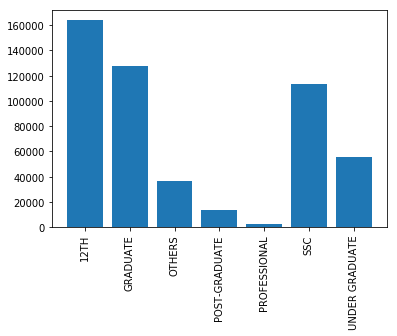

In [ ]:

b = [0] * len(a)
for i in range(len(a)):
  b[i] = data[(data['Qualifi.'] == a[i]) &(data['SELF_PAY']== 1)].shape[0]
plt.bar(a,b)
plt.xticks(rotation='vertical')
plt.show()

c = [0] * len(a)
for i in range(len(a)):
  c[i] = data[(data['Qualifi.'] == a[i]) &(data['SELF_PAY']== 0)].shape[0]
print(c)
print(a)
plt.bar(a,c)
plt.xticks(rotation='vertical')
plt.show()


Finding the ratio of self paid to not self paid individuals.

In [ ]:
d = [0] * len (a)
for i in range(len(a)):
  d[i] = b[i] / c[i]

e = zip(d,a)
e = list(e)
e = sorted(e)
f, g = zip(*e)
g = list(g)
print(g) # Ordered qualification on the basis of ratio of self paid divided by self unpaid people.
print(f)



['OTHERS', 'PROFESSIONAL', 'SSC', '12TH', 'UNDER GRADUATE', 'GRADUATE', 'POST-GRADUATE']
(0.034064728469555675, 0.04529115744069015, 0.053756785910063484, 0.05983093509833678, 0.06643059745984715, 0.09496501082624659, 0.10931383410887067)


Replacing the qualfication column with new categorical values

In [ ]:
h = list(range(0,7))
for i in range(7):
  data['Qualifi.'].replace(g[i], h[i], inplace = True)
#   data['Qualifi.'].replace(to_replace =g[i], value =h[i])
#   data.loc[data['Qualifi.'] == g[i], 'Qualifi.'] = h[i]
  
data.head()

        


,CUST_ID,Each Month Last Date,DateCA,ModelCode,DealerCode,AppDownloaded,Adv.EMIno,LoanTenure,EMI,DOB,AssetCost,Interest,LoanAmount,DownPayment,Qualifi.,BouncedTimes,Buss. Mon with Cust.,FuturePrinciple,OverallMaxLoanAmount,UnsecMaxLoanAmount,SecuredLoans,Timelastloan,TimelastpersonalLoan,TimelastLivepersonalLoan,TimelastClosedpersonalLoan,TimelastLiveBusinnessLoan,TimelastConsumerLoan,SELF_PAY,CAM,COOLER,DSW,EC,FRIDGE,HT,LAP,MOBILE,MWO,TV,WAM,WPR,RENTED,SELF,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,CNO000001,31-03-2019,21-09-2018,CD00124531,CD04818,1,3,10,1799,41,17990,5527,17990,5527,3,3,5,8994.73,17990.0,17990.0,0.0,191.0,0.0,0.0,0.0,0.0,191.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CNO000002,30-04-2019,21-09-2018,CD00124531,CD04818,1,3,10,1799,41,17990,5527,17990,5527,3,4,6,7195.82,17990.0,17990.0,0.0,221.0,0.0,0.0,0.0,0.0,221.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CNO000003,31-05-2019,21-09-2018,CD00124531,CD04818,1,3,10,1799,41,17990,5527,17990,5527,3,5,7,5396.89,17990.0,17990.0,0.0,252.0,0.0,0.0,0.0,0.0,252.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CNO000004,31-01-2019,21-06-2018,CD0005249,CD02428,1,2,12,2834,29,35900,3898,34000,5798,6,1,7,14168.46,34000.0,34000.0,0.0,224.0,0.0,0.0,0.0,0.0,224.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,CNO000005,30-04-2019,21-06-2018,CD0005249,CD02428,1,2,12,2834,29,35900,3898,34000,5798,6,2,10,5667.69,34000.0,34000.0,0.0,313.0,0.0,0.0,0.0,0.0,313.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


,CUST_ID,Each Month Last Date,DateCA,ModelCode,DealerCode,AppDownloaded,Adv.EMIno,LoanTenure,EMI,DOB,AssetCost,Interest,LoanAmount,DownPayment,Qualifi.,BouncedTimes,Buss. Mon with Cust.,FuturePrinciple,OverallMaxLoanAmount,UnsecMaxLoanAmount,SecuredLoans,Timelastloan,TimelastpersonalLoan,TimelastLivepersonalLoan,TimelastClosedpersonalLoan,TimelastLiveBusinnessLoan,TimelastConsumerLoan,SELF_PAY,CAM,COOLER,DSW,EC,FRIDGE,HT,LAP,MOBILE,MWO,TV,WAM,WPR,RENTED,SELF,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,CNO000001,31-03-2019,21-09-2018,CD00124531,CD04818,1,3,10,1799,41,17990,5527,17990,5527,3,3,5,8994.73,17990.0,17990.0,0.0,191.0,0.0,0.0,0.0,0.0,191.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CNO000002,30-04-2019,21-09-2018,CD00124531,CD04818,1,3,10,1799,41,17990,5527,17990,5527,3,4,6,7195.82,17990.0,17990.0,0.0,221.0,0.0,0.0,0.0,0.0,221.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CNO000003,31-05-2019,21-09-2018,CD00124531,CD04818,1,3,10,1799,41,17990,5527,17990,5527,3,5,7,5396.89,17990.0,17990.0,0.0,252.0,0.0,0.0,0.0,0.0,252.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CNO000004,31-01-2019,21-06-2018,CD0005249,CD02428,1,2,12,2834,29,35900,3898,34000,5798,6,1,7,14168.46,34000.0,34000.0,0.0,224.0,0.0,0.0,0.0,0.0,224.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,CNO000005,30-04-2019,21-06-2018,CD0005249,CD02428,1,2,12,2834,29,35900,3898,34000,5798,6,2,10,5667.69,34000.0,34000.0,0.0,313.0,0.0,0.0,0.0,0.0,313.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


(547308, 69)

In [ ]:
#removing the outliers
from scipy import stats
A = ['AssetCost', 'Interest', 'LoanAmount','DownPayment','BouncedTimes', 'FuturePrinciple', 'OverallMaxLoanAmount', 'UnsecMaxLoanAmount', 'Timelastloan', 'TimelastConsumerLoan']
for i in A:
  data = data[(np.abs(stats.zscore(data[i])) < 3)]

data.shape

(491785, 69)

In [ ]:
# For future checking purpose so that we dont have to run the DOB code. It takes too long. 
data_2 = data
data_2.head()

,CUST_ID,Each Month Last Date,DateCA,ModelCode,DealerCode,AppDownloaded,Adv.EMIno,LoanTenure,EMI,DOB,AssetCost,Interest,LoanAmount,DownPayment,Qualifi.,BouncedTimes,Buss. Mon with Cust.,FuturePrinciple,OverallMaxLoanAmount,UnsecMaxLoanAmount,SecuredLoans,Timelastloan,TimelastpersonalLoan,TimelastLivepersonalLoan,TimelastClosedpersonalLoan,TimelastLiveBusinnessLoan,TimelastConsumerLoan,SELF_PAY,CAM,COOLER,DSW,EC,FRIDGE,HT,LAP,MOBILE,MWO,TV,WAM,WPR,RENTED,SELF,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,CNO000001,31-03-2019,21-09-2018,CD00124531,CD04818,1,3,10,1799,41,17990,5527,17990,5527,3,3,5,8994.73,17990.0,17990.0,0.0,191.0,0.0,0.0,0.0,0.0,191.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CNO000002,30-04-2019,21-09-2018,CD00124531,CD04818,1,3,10,1799,41,17990,5527,17990,5527,3,4,6,7195.82,17990.0,17990.0,0.0,221.0,0.0,0.0,0.0,0.0,221.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CNO000003,31-05-2019,21-09-2018,CD00124531,CD04818,1,3,10,1799,41,17990,5527,17990,5527,3,5,7,5396.89,17990.0,17990.0,0.0,252.0,0.0,0.0,0.0,0.0,252.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CNO000004,31-01-2019,21-06-2018,CD0005249,CD02428,1,2,12,2834,29,35900,3898,34000,5798,6,1,7,14168.46,34000.0,34000.0,0.0,224.0,0.0,0.0,0.0,0.0,224.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,CNO000005,30-04-2019,21-06-2018,CD0005249,CD02428,1,2,12,2834,29,35900,3898,34000,5798,6,2,10,5667.69,34000.0,34000.0,0.0,313.0,0.0,0.0,0.0,0.0,313.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Seperating the dependent and independent variables

In [ ]:
Dep = data.loc[:, ~data.columns.isin(['SELF_PAY','Each Month Last Date','DateCA','CUST_ID'])]

# Indep = data.loc[data['SELF_PAY']]
Indep = data.loc[:, data.columns == 'SELF_PAY']
Dep.head()




,ModelCode,DealerCode,AppDownloaded,Adv.EMIno,LoanTenure,EMI,DOB,AssetCost,Interest,LoanAmount,DownPayment,Qualifi.,BouncedTimes,Buss. Mon with Cust.,FuturePrinciple,OverallMaxLoanAmount,UnsecMaxLoanAmount,SecuredLoans,Timelastloan,TimelastpersonalLoan,TimelastLivepersonalLoan,TimelastClosedpersonalLoan,TimelastLiveBusinnessLoan,TimelastConsumerLoan,CAM,COOLER,DSW,EC,FRIDGE,HT,LAP,MOBILE,MWO,TV,WAM,WPR,RENTED,SELF,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,CD00124531,CD04818,1,3,10,1799,41,17990,5527,17990,5527,3,3,5,8994.73,17990.0,17990.0,0.0,191.0,0.0,0.0,0.0,0.0,191.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CD00124531,CD04818,1,3,10,1799,41,17990,5527,17990,5527,3,4,6,7195.82,17990.0,17990.0,0.0,221.0,0.0,0.0,0.0,0.0,221.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CD00124531,CD04818,1,3,10,1799,41,17990,5527,17990,5527,3,5,7,5396.89,17990.0,17990.0,0.0,252.0,0.0,0.0,0.0,0.0,252.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CD0005249,CD02428,1,2,12,2834,29,35900,3898,34000,5798,6,1,7,14168.46,34000.0,34000.0,0.0,224.0,0.0,0.0,0.0,0.0,224.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,CD0005249,CD02428,1,2,12,2834,29,35900,3898,34000,5798,6,2,10,5667.69,34000.0,34000.0,0.0,313.0,0.0,0.0,0.0,0.0,313.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
!pip install category_encoders

     |████████████████████████████████| 102kB 2.7MB/s 


In [ ]:
import category_encoders as ce
# instantiate an encoder - here we use Binary()
ce_binary = ce.BinaryEncoder(cols = ['ModelCode'])
Dep = ce_binary.fit_transform(Dep, Indep)



In [ ]:
ce_binary = ce.BinaryEncoder(cols = ['DealerCode'])
# fit and transform and presto, you've got encoded data
Dep = ce_binary.fit_transform(Dep, Indep)

Dep.head()

,ModelCode_0,ModelCode_1,ModelCode_2,ModelCode_3,ModelCode_4,ModelCode_5,ModelCode_6,ModelCode_7,ModelCode_8,ModelCode_9,ModelCode_10,ModelCode_11,ModelCode_12,ModelCode_13,DealerCode_0,DealerCode_1,DealerCode_2,DealerCode_3,DealerCode_4,DealerCode_5,DealerCode_6,DealerCode_7,DealerCode_8,DealerCode_9,DealerCode_10,DealerCode_11,DealerCode_12,DealerCode_13,DealerCode_14,AppDownloaded,Adv.EMIno,LoanTenure,EMI,DOB,AssetCost,Interest,LoanAmount,DownPayment,Qualifi.,BouncedTimes,...,COOLER,DSW,EC,FRIDGE,HT,LAP,MOBILE,MWO,TV,WAM,WPR,RENTED,SELF,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,10,1799,41,17990,5527,17990,5527,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,10,1799,41,17990,5527,17990,5527,3,4,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,10,1799,41,17990,5527,17990,5527,3,5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2,12,2834,29,35900,3898,34000,5798,6,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2,12,2834,29,35900,3898,34000,5798,6,2,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


,CUST_ID,Each Month Last Date,DateCA,ModelCode,DealerCode,AppDownloaded,Adv.EMIno,LoanTenure,EMI,DOB,AssetCost,Interest,LoanAmount,DownPayment,Qualifi.,BouncedTimes,Buss. Mon with Cust.,FuturePrinciple,OverallMaxLoanAmount,UnsecMaxLoanAmount,SecuredLoans,Timelastloan,TimelastpersonalLoan,TimelastLivepersonalLoan,TimelastClosedpersonalLoan,TimelastLiveBusinnessLoan,TimelastConsumerLoan,SELF_PAY,CAM,COOLER,DSW,EC,FRIDGE,HT,LAP,MOBILE,MWO,TV,WAM,WPR,RENTED,SELF,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,CNO000001,31-03-2019,21-09-2018,CD00124531,CD04818,1,3,10,1799,41,17990,5527,17990,5527,3,3,5,8994.73,17990.0,17990.0,0.0,191.0,0.0,0.0,0.0,0.0,191.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CNO000002,30-04-2019,21-09-2018,CD00124531,CD04818,1,3,10,1799,41,17990,5527,17990,5527,3,4,6,7195.82,17990.0,17990.0,0.0,221.0,0.0,0.0,0.0,0.0,221.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CNO000003,31-05-2019,21-09-2018,CD00124531,CD04818,1,3,10,1799,41,17990,5527,17990,5527,3,5,7,5396.89,17990.0,17990.0,0.0,252.0,0.0,0.0,0.0,0.0,252.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CNO000004,31-01-2019,21-06-2018,CD0005249,CD02428,1,2,12,2834,29,35900,3898,34000,5798,6,1,7,14168.46,34000.0,34000.0,0.0,224.0,0.0,0.0,0.0,0.0,224.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,CNO000005,30-04-2019,21-06-2018,CD0005249,CD02428,1,2,12,2834,29,35900,3898,34000,5798,6,2,10,5667.69,34000.0,34000.0,0.0,313.0,0.0,0.0,0.0,0.0,313.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
Dep = Dep.values
Indep = Indep.values

PCA and CLASSIFICATION from here

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
Dep_train, Dep_test, Indep_train, Indep_test = train_test_split(Dep, Indep, test_size = 0.2, random_state = 0)


In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Dep_train = sc.fit_transform(Dep_train)
Dep_test = sc.transform(Dep_test)

In [ ]:
# # Applying LDA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# lda = LDA(n_components = 2)
# Dep_train = lda.fit_transform(Dep_train, Indep_train)
# Dep_test = lda.transform(Dep_test)

In [ ]:
# # Applying PCA
# from sklearn.decomposition import PCA
# pca = PCA(n_components = 2  )
# Dep_train = pca.fit_transform(Dep_train)
# Dep_test = pca.transform(Dep_test)
# explained_variance = pca.explained_variance_ratio_

In [ ]:
# # Applying Kernel PCA
# from sklearn.decomposition import KernelPCA
# kpca = KernelPCA(n_components = 2, kernel = 'rbf')
# Dep_train = kpca.fit_transform(Dep_train)
# Dep_test = kpca.transform(Dep_test)

In [ ]:
# # Fitting Logistic Regression to the Training set
# from sklearn.linear_model import LogisticRegression
# classifier = LogisticRegression(random_state = 0)
# classifier.fit(Dep_train, Indep_train)

# # Predicting the Test set results
# Indep_pred = classifier.predict(Dep_test)

In [ ]:
# # Making the Confusion Matrix
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(Indep_test, Indep_pred)
# cm

In [ ]:
# Accuracy = (cm[0][0] + cm[1][1]) / sum(sum(cm))
# # 
# Accuracy * 100

Checking different algorithms and their accuracy

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

#Analyzing which classifier is the best for the task using confusion matrix and checking the accuracy
classifiers = []
model_1 = XGBClassifier()
classifiers.append(model_1)
model_2 = tree.DecisionTreeClassifier()
classifiers.append(model_2)
model_3 = RandomForestClassifier()
classifiers.append(model_3) 
model_4 = LogisticRegression()
classifiers.append(model_4)
# model_5 = GaussianNB()
# classifiers.append(model_5)
 


df= pd.DataFrame([])
for clf, name in zip(classifiers, ['XGBoost', 'Decision Tree', 'Random Forest', 'Logistic Regression']):
    clf.fit(Dep_train, Indep_train)
    Indep_pred= clf.predict(Dep_test)
    acc = accuracy_score(Indep_test, Indep_pred)*100
    df = df.append(pd.DataFrame({'Name of model' : name ,'Accuracy': acc}, index=[0]), ignore_index=True)
    cm = confusion_matrix(Indep_test, Indep_pred)
    print("Confusion Matrix of %s is %s"%(clf, cm))

print(df)
print("Best classifier is ",df.loc[df['Accuracy'].idxmax(), 'Name of model'], "and its accuracy is ", df['Accuracy'].max())

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) is [[92347    92]
 [ 5666   252]]
Confusion Matrix of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best') is [[87647  4792]
 [ 3788  2130]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Confusion Matrix of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) is [[92065   374]
 [ 5017   901]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) is [[92391    48]
 [ 5868    50]]
         Name of model   Accuracy
0              XGBoost  94.145816
1        Decision Tree  91.276676
2        Random Forest  94.518946
3  Logistic Regression  93.985176
Best classifier is  Random Forest and its accuracy is  94.51894628750368


In [ ]:
# Then we create the CAP Curve with the following code :
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(Dep_train, Indep_train)
Indep_pred= clf.predict(Dep_test) 

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
total = len(Indep_test)

class_1_count = np.sum(Indep_test)

class_0_count = total - class_1_count

plt.figure(figsize = (20, 12))
print(class_1_count)

5918


<Figure size 1440x864 with 0 Axes>

Accuracy Rate for Support Vector Classifier: 0.7998589726065106


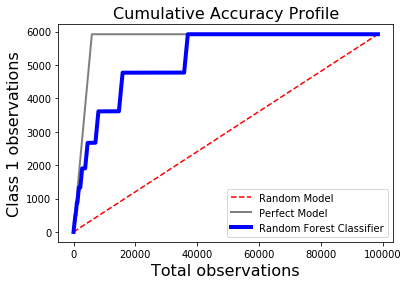

In [ ]:
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
leg = plt.legend()
plt.legend(loc='lower right', frameon=False)



plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')
leg = plt.legend()
plt.legend(loc='lower right', frameon=False)



plt.plot(x_values, 
         y_values, 
         c = 'b', 
         label = 'Random Forest Classifier', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Class 1 observations', fontsize = 16)
plt.title('Cumulative Accuracy Profile', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 10)




Accuracy Rate for Support Vector Classifier: 0.7998589726065106


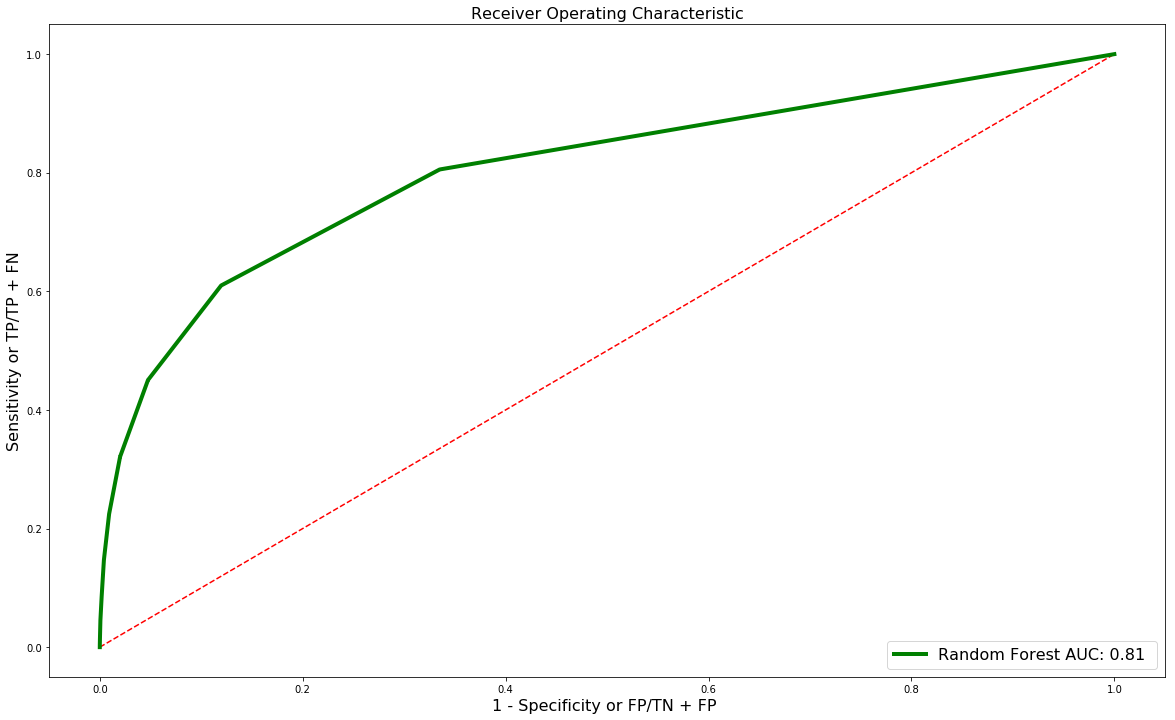

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (20, 12))
plt.plot([0,1], [0,1], 'r--')

probs = classifier.predict_proba(Dep_test)
# Reading probability of second class (Salary >= $200K)
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(Indep_test, probs)
roc_auc = auc(fpr, tpr)

label = 'Random Forest AUC:' + ' {0:.2f} '.format(roc_auc)
plt.plot(fpr, tpr, c = 'g', label = label, linewidth = 4)
plt.xlabel('1 - Specificity or FP/TN + FP ', fontsize = 16)
plt.ylabel('Sensitivity or TP/TP + FN', fontsize = 16)
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)


SyntaxError: ignored